In [1]:
import numpy as np
import matplotlib.pyplot as plt
import chaosmagpy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import pandas as pd
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
import scipy

# def functions

In [2]:
def dx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dxm)
    der[:, 0] = (f[:, 1] - f[:, -2]) / (2 * dxm)
    der[:, -1] = der[:, 0]
    return der

In [3]:
def dy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dym)
    der[0, :] = (f[1, :] - f[0, :]) / (dym)
    der[1, :] = (f[-1, :] - f[-2, :]) / (dym)
    return der

In [4]:
def ddy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, 1, axis=0) - 2 * f + np.roll(f, -1, axis=0)) / (dym ** 2)
    der[0, :] = der[1, :]
    der[-1, :] = der[-2, :]
    return der

In [5]:
def ddx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, 1, axis=1) - 2 * f + np.roll(f, -1, axis=1)) / (dxm ** 2)
    der[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -2]) / (dxm ** 2)
    der[:, -1] = der[:, 0]
    return der

In [6]:
def ddxy(ym, xm, f):
    df_dx = dx(ym, xm, f)
    ddf_dxy = dy(ym, xm, df_dx)
    return ddf_dxy

In [7]:
def detH(ddx,ddy,ddxy):
    derH=(ddx*ddy)
    return derH

In [8]:
def calculate_integral(B):
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)  # lon
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)  # lat

    integrals = [0, 0]  
    theta_min = np.deg2rad(25)   
    theta_max = np.deg2rad(155)  
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],  
        [(0, 2 * np.pi), (theta_max, np.pi)] ]
    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and region[1][0] <= (theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta
    integral = sum(integrals)
    return integral

In [13]:
def F_C_ObO(x, y, fun1, fun2, lev):
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])

    Line_dx=[]
    points_dx=[]
    paths = c_fx.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dx.extend(verts)
        FxLine=[]
        for v in range(len(verts) - zz):
            xa, ya = verts[v]
            xb, yb = verts[v+1]
            xlist = np.array([xa, xb])
            ylist = np.array([ya, yb])
            # Skip if two points are too close (to avoid polyfit failure)
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"Warning: polyfit failed for points ({xa}, {ya}) - ({xb}, {yb}), skipped.")
                continue
            k, b = np.polyfit(xlist, ylist, deg=1)
            FxLine.append([k, b, xa, xb, ya, yb])
        Line_dx.append(np.array(FxLine))

    Line_dy=[]
    points_dy=[]
    paths = c_fy.get_paths()
    polygons = paths[0].to_polygons()
    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1,0]-verts[-2,0])>10 or abs(verts[-1,1]-verts[-2,1])>10:
            zz=2
        else:
            zz=1
        points_dy.extend(verts)
        FyLine=[]
        for v in range(len(verts) - zz):
            xa, ya = verts[v]
            xb, yb = verts[v+1]
            xlist = np.array([xa, xb])
            ylist = np.array([ya, yb])
            # Skip if two points are too close (to avoid polyfit failure)
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue
            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"Warning: polyfit failed for points ({xa}, {ya}) - ({xb}, {yb}), skipped.")
                continue
            k, b = np.polyfit(xlist, ylist, deg=1)
            FyLine.append([k, b, xa, xb, ya, yb])
        Line_dy.append(np.array(FyLine))

    x_cross=[]
    y_cross=[]
    for n in range(len(Line_dx)):
        Fx = Line_dx[n]
        for m in range(len(Line_dy)):
            Fy = Line_dy[m]
            for p in range(len(Fx[:,0])):
                k1, b1, x1, x2, y1, y2 = Fx[p, :]
                for q in range(len(Fy[:,0])):
                    k2, b2, x3, x4, y3, y4 = Fy[q, :]
                    x_c = (b2 - b1) / (k1 - k2)
                    if x_c is not None:
                        # Check if x_c is within the x-range of both line segments
                        in_range_1 = (min(x1, x2) <= x_c <= max(x1, x2))
                        in_range_2 = (min(x3, x4) <= x_c <= max(x3, x4))
                        if in_range_1 and in_range_2:
                            y_c = k1 * x_c + b1
                            if y_c is not None:
                                # Check if y_c is within the y-range of both line segments
                                in_range_3 = (min(y1, y2) <= y_c <= max(y1, y2))
                                in_range_4 = (min(y3, y4) <= y_c <= max(y3, y4))
                                if in_range_3 and in_range_4:
                                    x_cross.append(x_c)
                                    y_cross.append(y_c)

    x_cross = np.array(x_cross)
    y_cross = np.array(y_cross)

    # Create boolean mask to keep points where y is in [5, 175]
    mask = (y_cross >= 5) & (y_cross <= 175)
    x_cross = x_cross[mask]
    y_cross = y_cross[mask]
    return x_cross, y_cross


def detH_saddle(DETH, thetam, phim, crossingsX, crossingsY):
    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]
    interp_func = scipy.interpolate.RegularGridInterpolator((lat_grid, lon_grid), DETH, bounds_error=False, fill_value=np.nan)
    
    cross = np.column_stack((crossingsX, crossingsY))
    cross = np.array(cross)
    points_for_interp = cross[:, [1, 0]]
    
    # Interpolate DETH values at crossing points
    values = interp_func(points_for_interp)

    # Separate points based on sign of interpolated DETH
    pos_mask = values > 0
    neg_mask = values <= 0
    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points


# FOR IN CHAOS

In [11]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')

time = cp.data_utils.mjd2000(2020, 1, 1)  # modified Julian date
B_radius_2020, B_theta_2020, B_phi_2020 = model.synth_values_tdep(time, radiusm, thetam, phim)
F2020 = np.sqrt(B_radius_2020 ** 2 + B_theta_2020 ** 2 + B_phi_2020 ** 2) / 1000
Fo2020=calculate_integral(F2020)

D:\Anaconda\envs\Saddle\Lib\site-packages\chaosmagpy\chaos.py:2873: UserWarning: Missing ionospheric field coefficients: 'model_ion'
  warnings.warn(f'Missing ionospheric field coefficients: {err}')


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


8


D:\Anaconda\envs\Saddle\Lib\site-packages\cartopy\io\__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


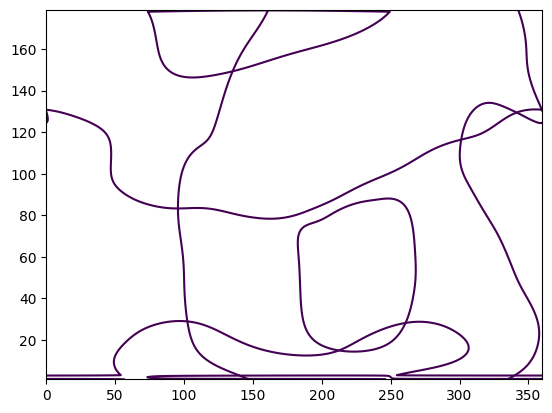

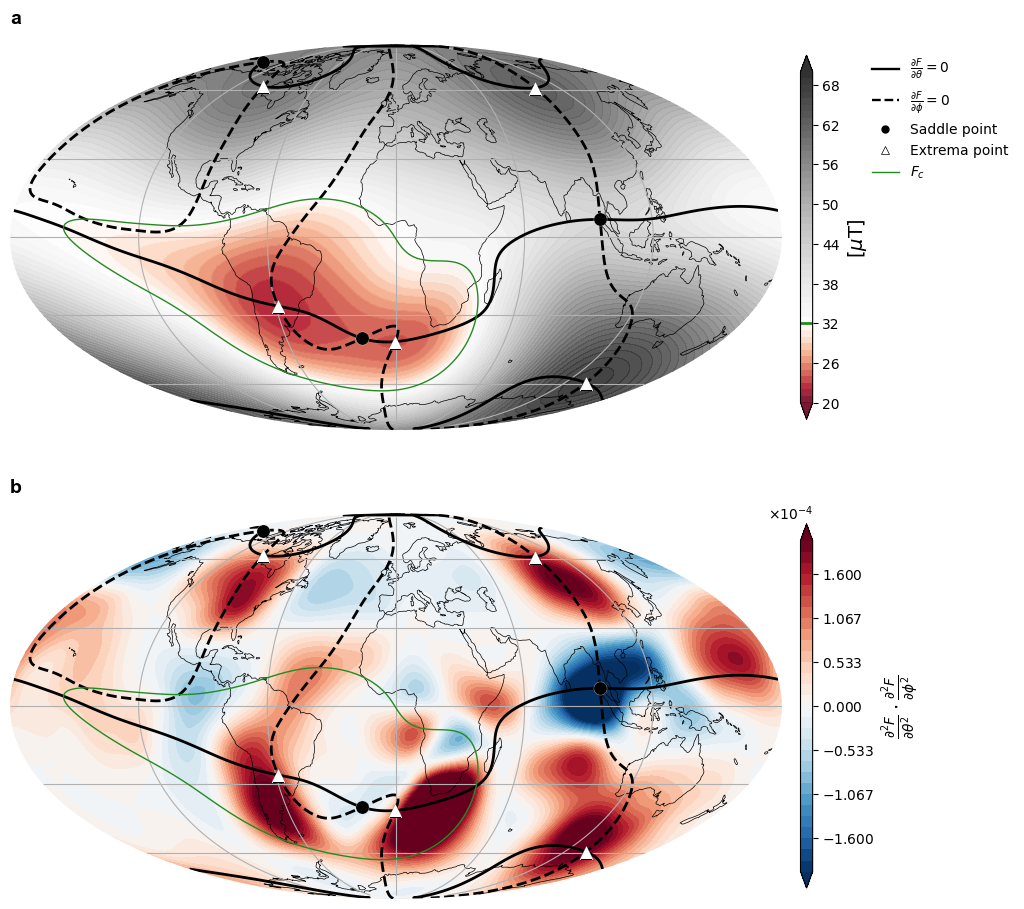

In [14]:
records_max=[]; 
records_min=[]; 
records_saddle=[]

fontweight='bold'; fontname='Arial'; fontsize=14
Cmap='RdGy'; markersize=90
SaddleColor='k'; SaddleMarker='o'; ExtremaColor='white'; ExtremaMarker='^'; linecolor='forestgreen'
vmin=20; vmax=70; yr=2020

# ---- CHAOS-8 field
time=cp.data_utils.mjd2000(yr,1,1)
B_radius,B_theta,B_phi=model.synth_values_tdep(time,radiusm,thetam,phim)
F=np.sqrt(B_radius**2+B_theta**2+B_phi**2)/1000
Fout=calculate_integral(F); Fc=32*(Fout/Fo2020)
vcenter=Fc
norm=mcolors.TwoSlopeNorm(vmin=vmin,vcenter=vcenter,vmax=vmax)

F_real=F
d_x=dx(thetam,phim,F_real); d_y=dy(thetam,phim,F_real)
dd_x=ddx(thetam,phim,F_real); dd_y=ddy(thetam,phim,F_real); dd_xy=ddxy(thetam,phim,F_real)
DETH=detH(dd_x,dd_y,dd_xy)
crossingsX1,crossingsY1=F_C_ObO(phi,theta,d_x,d_y,0)
E,S=detH_saddle(DETH,thetam,phim,crossingsX1,crossingsY1)
H_S_lat,H_S_lon=S[:,0],S[:,1]; H_E_lat,H_E_lon=E[:,0],E[:,1]
print(len(crossingsX1))

plt.figure(figsize=(12,12))

# ---- Top panel: F field
ax1=plt.subplot(2,1,1,projection=ccrs.Mollweide())
ax1.set_global(); ax1.coastlines(linewidth=0.5)
ax1.add_feature(cfeature.LAND,facecolor='lightgray',linewidth=0.5)
ax1.gridlines(draw_labels=False)
for spine in ax1.spines.values(): spine.set_visible(False)

C=np.linspace(20,70,51)
cb=ax1.contourf(phi,90-theta,F_real,C,cmap=Cmap,transform=ccrs.PlateCarree(),extend='both',alpha=0.9,norm=norm)
ax1.scatter(H_E_lon,90-H_E_lat,color=ExtremaColor,marker=ExtremaMarker,s=markersize,transform=ccrs.PlateCarree(),zorder=5,edgecolors='k',linewidths=0.1)
ax1.scatter(H_S_lon,90-H_S_lat,color=SaddleColor,marker=SaddleMarker,s=markersize,transform=ccrs.PlateCarree(),zorder=5,edgecolors='white',linewidths=0.2)

ax1.contour(phi,90-theta,d_y,levels=[0],colors='k',linewidths=2,transform=ccrs.PlateCarree())
ax1.contour(phi,90-theta,d_x,levels=[0],colors='k',linewidths=2,transform=ccrs.PlateCarree(),linestyles='dashed')
ax1.contour(phi,90-theta,F_real,levels=[Fc],colors=linecolor,linewidths=1,transform=ccrs.PlateCarree())
cb=plt.colorbar(cb,orientation='vertical',pad=0.02,aspect=30,shrink=0.8)
cb.ax.axhline(Fc,color=linecolor,linewidth=2)
cb.set_label(r'[$\mu$T]',fontsize=fontsize)

legend_elements=[
    Line2D([0],[0],color='k',lw=1.7,label=r'$\frac{\partial F}{\partial \theta}=0$'),
    Line2D([0],[0],color='k',lw=1.7,label=r'$\frac{\partial F}{\partial \phi}=0$',linestyle='dashed'),
    Line2D([0],[0],marker=SaddleMarker,color=SaddleColor,label='Saddle point',markersize=5,linestyle='None'),
    Line2D([0],[0],color=ExtremaColor,marker=ExtremaMarker,label='Extrema point',markersize=6,linestyle='None',markeredgecolor='k',markeredgewidth=0.5),
    Line2D([0],[0],color=linecolor,lw=1,label=r'$F_c$')
]
ax1.legend(handles=legend_elements,loc='upper left',bbox_to_anchor=(1.1,1.0),frameon=False)
ax1.text(0,1.09,'a',transform=ax1.transAxes,fontsize=fontsize,fontweight=fontweight,fontname=fontname,va='top')

# ---- Bottom panel: Hessian determinant
ax2=plt.subplot(2,1,2,projection=ccrs.Mollweide())
ax2.set_global(); ax2.coastlines(linewidth=0.5)
ax2.add_feature(cfeature.LAND,facecolor='lightgray',linewidth=0.5)
ax2.gridlines(draw_labels=False)
for spine in ax2.spines.values(): spine.set_visible(False)

C=np.linspace(-0.0002,0.0002,31)
cb=ax2.contourf(phi,90-theta,DETH,C,cmap='RdBu_r',transform=ccrs.PlateCarree(),extend='both')
ax2.scatter(H_E_lon,90-H_E_lat,color=ExtremaColor,marker=ExtremaMarker,s=markersize,transform=ccrs.PlateCarree(),zorder=5,edgecolors='k',linewidths=0.1)
ax2.scatter(H_S_lon,90-H_S_lat,color=SaddleColor,marker=SaddleMarker,s=markersize,transform=ccrs.PlateCarree(),zorder=5,edgecolors='white',linewidths=0.2)

ax2.contour(phi,90-theta,d_y,levels=[0],colors='k',linewidths=2,transform=ccrs.PlateCarree())
ax2.contour(phi,90-theta,d_x,levels=[0],colors='k',linewidths=2,transform=ccrs.PlateCarree(),linestyles='dashed')
ax2.contour(phi,90-theta,F_real,levels=[Fc],colors=linecolor,linewidths=1,transform=ccrs.PlateCarree())
cb=plt.colorbar(cb,orientation='vertical',pad=0.02,aspect=30,shrink=0.8)
cb.set_label(r'$\frac{\partial^2 F}{\partial \theta^2} \cdot \frac{\partial^2 F}{\partial \phi^2}$',fontsize=fontsize)
cb.formatter=ScalarFormatter(useMathText=True); cb.formatter.set_scientific(True); cb.formatter.set_powerlimits((-3,3)); cb.update_ticks()

ax2.text(0,1.09,'b',transform=ax2.transAxes,fontsize=fontsize,fontweight=fontweight,fontname=fontname,va='top')

plt.subplots_adjust(hspace=0.03)
# plt.savefig(r'D:\\work\\work_saddle\\Latex_saddle\\Fig\\New-color\\F3-contour Method.png',dpi=300,bbox_inches='tight')
